In [ ]:
import sys
sys.path.append('../utils/')

In [ ]:
from ImageUtils import *

In [ ]:
import numpy as np
import pandas as pd # Needs the package Pandas to be installed. Check Anaconda Environments and Packages.
from sklearn.decomposition import PCA # Needs SciKit Learn package to be installed. Check Anaconda Environments and Packages.4
from sklearn.covariance import LedoitWolf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from collections import Counter
from sklearn.preprocessing import label_binarize
import time

# Data preparation

## Load dataset

In [ ]:
faces94_male = readFaces94MaleFaces(gray=True)
faces94_female = readFaces94FemaleFaces(gray=True)
faces94_malestaff = readFaces94MaleStaffFaces(gray=True)

dataset = np.vstack((faces94_male, faces94_female, faces94_malestaff))

dataset_N, height, width = dataset.shape
dataset.shape

## Data centralization and calculate of covariance matrix

In [ ]:
mean_all = np.mean(dataset.reshape(dataset_N, height*width), axis=0).reshape(height, width)
plt.imshow(mean_all, plt.cm.gray)

In [ ]:
data=dataset.reshape(dataset_N, height*width) - np.mean(dataset.reshape(dataset_N, height*width), axis=0)
datasetmean=(1/(dataset_N-1))*(np.dot(data,data.T)) # Covariance matrix
print(datasetmean.shape)

# Subspaces method: Eigenfaces

## Singular Value Decomposition.

In [ ]:
u,s,vh = np.linalg.svd(datasetmean) # u: eigenvectors in columns; s: eigenvalues; vh = eigenvectors in rows

In [ ]:
#print(u[:,0:4].shape) #para seleccionar columnas de u o s

## Face space: selection of subspace components

### Option 1: Investigator's criteria of variability captured (hyperparameter)

In [ ]:
representation_percentage = 0.98 # Selected variability 

In [ ]:

sum_eig = np.sum(s)
percentage_variance = np.divide(s, sum_eig)
sum_var = 0
num_var = 0
for i in np.arange(percentage_variance.shape[0]):
    if sum_var >= representation_percentage:
        num_var = i
        break;
    
    sum_var += percentage_variance[i]
    
print("Principal components number: ",num_var)
print("Percent of variability captured: ",sum_var*100)
print("Images in datasets",dataset_N)

### Option 2: Investigator's criteria of threshold contribution value (hyperparameter)

In [ ]:
cum_per=np.cumsum(percentage_variance)
for i in range(1,len(s)):
    change=(cum_per[i]-cum_per[i-1])/cum_per[i-1]*100
    if(change<.01):
        num_var=i-1
        print("First",num_var, "components with ",cum_per[num_var]*100,"percent of variability captured and from which the contribution is less than 0.01%")
        break

plt.figure(figsize=(12,6))
plt.plot(cum_per*100)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cumulative Summation of the Explained Variance')
plt.show()

# Face space

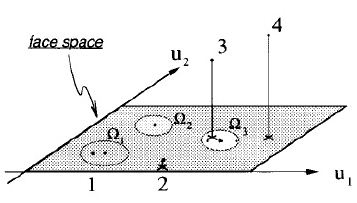

In [ ]:
from sklearn import preprocessing 
EigenvectorsA=np.dot(data.T,u[:,0:num_var])
NormEigenvectorsA = preprocessing.normalize(EigenvectorsA,axis=0, norm='l2') # Face space
print(np.linalg.norm(NormEigenvectorsA[:,5],ord=None))#check normalization vectores propios de XT.X

In [ ]:
cols = 4
rows = 4
plt.figure(figsize=(30,20))
for i in np.arange(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(NormEigenvectorsA[:,i].reshape(height, width), plt.cm.gray)

# Projection of an image on face space

In [ ]:
N_image= 1071
Image=data[N_image] # Selection of random face
w=np.dot(Image,NormEigenvectorsA)#weigth w of each Eigenface in generate subspace
#Recunstructed=np.sum(w*NormEigenvectorsA,axis=1)+mean_all.reshape(height*width)#otra forma de construir la imagen
Reconstructed=np.dot(w,NormEigenvectorsA.T)+mean_all.reshape(height*width)#es mas claro w*vectores propios transpuestos

In [ ]:
example_image = Reconstructed
original_image = dataset[N_image]
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Original Image")
ax1.imshow(original_image, plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Reconstructed Image")
ax2.imshow(example_image.reshape(height,width), plt.cm.gray)

In [ ]:
image_index = np.random.randint(0, high=dataset_N, size=1)[0]
example_image = np.dot(np.dot(data[image_index],NormEigenvectorsA),NormEigenvectorsA.T)+mean_all.reshape(height*width)
original_image = dataset[image_index]
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Original Image")
ax1.imshow(original_image, plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Reconstructed Image")
ax2.imshow(example_image.reshape(height,width), plt.cm.gray)

# Distances an outliers

In [ ]:
dataReconstructed=np.dot(np.dot(data,NormEigenvectorsA),NormEigenvectorsA.T)+mean_all.reshape(height*width)
print(dataReconstructed.shape)

In [ ]:
Norm=2
edistance = np.linalg.norm(np.subtract(dataReconstructed, dataset.reshape(dataset_N, height*width)), ord=Norm, axis=1)
print(edistance.shape)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('Histogram')
plt.grid(True)
plt.hist(edistance);
plt.subplot(1,2,2)
plt.title('Boxplot')
plt.boxplot(edistance, 0, 'rs', 0);
plt.show()

In [ ]:
#outliers
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(edistance))
threshold = 3
outliers=np.where(z > threshold)
quartile_1, quartile_3 = np.percentile(edistance, [25, 75])
indexsort=np.argsort(edistance) #indice de imagenes distance de menor a mayor
edistancesort=edistance[indexsort] #distancias de imagenes menor a mayor
print('Outliers IQ method=',np.size(outliers))
print('Q1= ',quartile_1, 'Q3= ',quartile_3)
print(edistance[outliers[0]])#validar en pandas

In [ ]:
#grafica distancia minima y maxima
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Similar Image")
ax1.imshow(dataset[indexsort[0]], plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Dissimilar Image")
ax2.imshow(dataset[indexsort[-1]], plt.cm.gray)

In [ ]:
#mayores distancias
cols = 3
rows = 3
plt.figure(figsize=(30,20))
for i in np.arange(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(dataset[indexsort[-(i+1)]], plt.cm.gray)

# Face recognition dataset

In [ ]:
landscapes = np.array(readLandsCapeImage(gray=True))
N_land= np.random.randint(0, high=landscapes.shape[0], size=1)[0]
landimage=landscapes[N_land].reshape(height*width)-mean_all.reshape(height*width)#seleccionar imagen individual
wland=np.dot(landimage,NormEigenvectorsA)#pesos w de cada Eigenface en subespacio generado
Reconstland=np.dot(wland,NormEigenvectorsA.T)+mean_all.reshape(height*width)#es mas claro w*vectores propios transpuestos
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Land image")
ax1.imshow(landscapes[N_land], plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Reconstructed land Image")
ax2.imshow(Reconstland.reshape(height, width), plt.cm.gray)

In [ ]:
Norm=2
edistanceland = np.linalg.norm(np.subtract(landscapes[N_land].reshape(height*width), Reconstland), ord=Norm, axis=0)

quartile= np.percentile(edistance,100)

if edistanceland>quartile:
        print('No pertenece al dataset')
else:
        print('error')
print(quartile) 
print(edistanceland)    


# classes

In [ ]:
dataclass1=faces94_female
dataset_N2, height, width = dataclass1.shape
mean_class1 = np.mean(dataclass1.reshape(dataset_N2, height*width), axis=0)
plt.imshow(mean_class1.reshape(height, width), plt.cm.gray)

In [ ]:
omegaclass1=mean_class1 - np.mean(dataset.reshape(dataset_N, height*width), axis=0)
wclass1=np.dot(omegaclass1,NormEigenvectorsA)#pesos w de cada Eigenface en subespacio generado
Reconstructedc1=np.dot(wclass1,NormEigenvectorsA.T)+mean_all.reshape(height*width)#es mas claro w*vectores propios transpuestos


fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Female mean")
ax1.imshow(mean_class1.reshape(height, width), plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Reconstructed Female mean")
ax2.imshow(Reconstructedc1.reshape(height, width), plt.cm.gray)

In [ ]:
class1=dataclass1.reshape(dataset_N2, height*width)-mean_all.reshape(height*width)
wclass1total=np.dot(class1,NormEigenvectorsA)
print(wclass1total.shape)
print(wclass1.shape)

In [ ]:
Norm=2
edistanceclass1 = np.linalg.norm(np.subtract(wclass1total, wclass1), ord=Norm, axis=1)
print(edistanceclass1.shape)
print(wclass1.shape)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('Histogram')
plt.grid(True)
plt.hist(edistanceclass1);
plt.subplot(1,2,2)
plt.title('Boxplot')
plt.boxplot(edistanceclass1, 0, 'rs', 0);
plt.show()

In [ ]:
quartile_1, quartile_3 = np.percentile(edistanceclass1, [25, 75])


image_index = np.random.randint(0, high=dataset_N, size=1)[0]
Imagetest=dataset[image_index].reshape(height*width) - np.mean(dataset.reshape(dataset_N, height*width), axis=0)
wtest=np.dot(Imagetest,NormEigenvectorsA)

Norm=2
test = np.linalg.norm(np.subtract(wtest, wclass1), ord=Norm, axis=0)

if test>quartile_3:
        print('no es mujer')
else:
        print('es mujer')
print(quartile_3) 
print(test)    
   
plt.imshow(dataset[image_index], plt.cm.gray)



In [ ]:
Norm=2
edistanceclass1t = np.linalg.norm(np.subtract(np.dot(data,NormEigenvectorsA), wclass1), ord=Norm, axis=1)
print(edistanceclass1t.shape)
print(wclass1.shape)
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('Histogram')
plt.grid(True)
plt.hist(edistanceclass1t);
plt.subplot(1,2,2)
plt.title('Boxplot')
plt.boxplot(edistanceclass1t, 0, 'rs', 0);
plt.show()